In [40]:
import numpy as np
import matplotlib.pylab as plt
import sklearn
from skimage import io
import tensorflow as tf
%matplotlib inline

from load_animals import *
from influence.iter_attack import get_projection_to_box_around_orig_point
from influence.inceptionModel import BinaryInceptionModel
from data_poisoning import data_poisoning
from sklearn.linear_model import LogisticRegression

from utils import dataset_metadatas, experiment_result_metadata_to_FN, FN_to_experiment_result_metadata, get_dataset, render_img, get_full_model_graph

import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
def parse_file_name_exp2(fn):
    fn = fn[:-4]
    lst = fn.split('_')
    content_type = lst[2]
    approach = lst[3]
    target_label = lst[7]
    test_idx = lst[-1]
    return {
        "content_type": content_type,
        "approach": approach,
        "target_label": target_label,
        "test_idx": test_idx
    }

def sorted_dir_exp2(folder, order_by = False):
    def getmtime(name):
        path = os.path.join(folder, name)
        return os.path.getmtime(path)
    def order(name):
        if name == '.ipynb_checkpoints' or name == 'Analysis': return (1000, 1000)
        file = parse_file_name_exp2(name)
        return (file['approach'],int(file["test_idx"]), int(file["target_label"]) + int(file["test_idx"]))
    
    if order_by:
        return sorted(os.listdir(folder), key=order)

    return sorted(os.listdir(folder), key=getmtime, reverse=True)

In [3]:
dataset_classes = dataset_metadatas["Eagle-Mushroom-Snail"]
data_sets = get_dataset(dataset_classes)

Loading animals from disk...
../data/dataset_Eagle-Mushroom-Snail_train-500_test-50.npz


In [4]:
full_graph, full_model = get_full_model_graph(dataset_classes, data_sets)

self.logits Tensor("Shape:0", shape=(2,), dtype=int32)


[genericNeuralNet.py:191 -   get_vec_to_list_fn() ] Total number of parameters: 6144
/home/ubuntu/anaconda3/envs/influence_env/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


wrong_labels_bool Tensor("Shape_2:0", shape=(2,), dtype=int32)
logits Tensor("Shape_3:0", shape=(2,), dtype=int32)
inception_features:  Tensor("flatten/Reshape:0", shape=(?, ?), dtype=float32)
x_poison_features:  Tensor("StridedSlice:0", dtype=float32)
t_target_features:  Tensor("Gather:0", shape=(1, ?), dtype=float32)
Lp:  Tensor("Mean_1:0", dtype=float32)
LP_gradient Tensor("strided_slice_1:0", shape=(?, 268203), dtype=float32)


In [5]:
C = 1.0 / (len(data_sets.train.x) * .001) 
top_model = LogisticRegression(
                        C=C,
                        tol=1e-8,
                        fit_intercept=False, 
                        solver='lbfgs',
                        multi_class='multinomial',
                        warm_start=True, #True
                        max_iter=1000) 

In [6]:
with full_graph.as_default():
    clean_inception_features = full_model.generate_inception_features(data_sets.train, None) 

In [24]:
def exp2_analysis(approach):

    source_dir = "Experiment_results/Experiment_2_with_8/" 
    file_names = list((sorted_dir_exp2(source_dir, True)))
    if 'Analysis' in file_names:
        file_names.remove('Analysis')
    if '.ipynb_checkpoints' in file_names:
        file_names.remove('.ipynb_checkpoints')

    poisoned_train_indices, poisoned_images, target_test_indices, target_labels = [], [], [], []
    for i in range(0, len(file_names), 2):
        file_name = file_names[i]
        # only look at the results from the specified dataset
        file = parse_file_name_exp2(file_name)
        if file["approach"] == approach:
            if file["content_type"] == 'indices':
                poisoned_train_index = np.load(source_dir + file_name)
                poisoned_image = np.load(source_dir + file_names[i+1])
            else:
                poisoned_train_index = np.load(source_dir + file_names[i+1])
                poisoned_image = np.load(source_dir + file_name)
            target_test_index = file['test_idx']
            poisoned_images.append(poisoned_image)
            poisoned_train_indices.append(poisoned_train_index)
            target_test_indices.append(target_test_index)
            target_labels.append(file['target_label'])

    polluted_inception_features = []
    with full_graph.as_default():
        for poison_image, poisoned_train_index in zip(poisoned_images, poisoned_train_indices):
            poisoned_dataset = DataSet(poison_image, data_sets.train.labels[poisoned_train_index.astype(int)])
            polluted_inception_feature = full_model.generate_inception_features(poisoned_dataset, None)
            polluted_inception_features.append(polluted_inception_feature)

    path_to_save = "Experiment_results/Experiment_2_with_8/Analysis/" + approach + '/'

    for counter, (polluted_inception_feature, poisoned_train_index, target_test_index, target_label) in enumerate(zip(polluted_inception_features, poisoned_train_indices, target_test_indices, target_labels)):
        target_test_dataset = DataSet(np.copy(data_sets.test.x[[int(target_test_index)]]), np.copy(data_sets.test.labels[[int(target_test_index)]]))
        with full_graph.as_default():
            target_test_inception_feature = full_model.generate_inception_features(target_test_dataset, None)   
        X, Y = np.copy(clean_inception_features), np.copy(data_sets.train.labels)
        X[poisoned_train_index.astype(int)] = polluted_inception_feature
        top_model.fit(X, Y)    
        logits_true_label = top_model.predict_proba(target_test_inception_feature)[0][int(data_sets.test.labels[int(target_test_index)])]
        experiment_result_metadata = {
        "Experiment_number":2,
        "contents_type":"logits",
        "method":approach,
        "dataset_name":dataset_classes["name"],
        "num_poisoned_training_points":int(target_label),
        "test_idx":int(data_sets.test.labels[int(target_test_index)])
        }
        FN = experiment_result_metadata_to_FN(experiment_result_metadata)
        np.save(path_to_save+experiment_result_metadata_to_FN(experiment_result_metadata)+"_" +str(counter), logits_true_label)


In [26]:
exp2_analysis('IF')

(0, '0')
(0, '0')
(0, '1')
(0, '1')
(1, '50')
(1, '50')
(1, '51')
(1, '51')
(1, '52')
(1, '52')
(1, '53')
(1, '53')
(1, '54')
(1, '54')
(1, '55')
(1, '55')
(2, '100')
(2, '100')
(2, '102')
(2, '102')
(2, '103')
(2, '103')
(2, '104')
(2, '104')
(2, '105')
(2, '105')


In [21]:
exp2_analysis('FC')

In [126]:
# True stands for M <-> S
# False stands for E <-> M/S
target_type = True

In [8]:
def parse_file_name_exp2_plotting(fn):
    fn = fn[:-4]
    lst = fn.split('_')
    approach = lst[3]
    test_label = lst[-2]
    train_label = lst[7]
    return {
        "train_label": train_label,
        "approach": approach,
        "test_label": test_label,
    }

def sorted_dir_exp2_plotting(folder):
    def getmtime(name):
        path = os.path.join(folder, name)
        return os.path.getmtime(path)
    return sorted(os.listdir(folder), key=getmtime, reverse=True)

In [31]:
def get_logits_given_approach(approach):
    source_dir = "Experiment_results/Experiment_2_with_8/Analysis/" + approach + '/' 
    file_names = list((sorted_dir_exp2_plotting(source_dir)))
    if 'Analysis' in file_names:
        file_names.remove('Analysis')
    if '.ipynb_checkpoints' in file_names:
        file_names.remove('.ipynb_checkpoints')

    train_labels, test_labels, logits = [], [], []

    for file_name in file_names:
        file = parse_file_name_exp2_plotting(file_name)
        train_labels.append(file['train_label'])
        test_labels.append(file['test_label'])
        logits.append(np.load(source_dir+file_name))
    return train_labels, test_labels, logits

In [44]:
results_all = [[], [], [], []]
for approach in ['IF', 'FC']:
    index = 0 if approach == 'IF' else 2
    train_labels, test_labels, logits = get_logits_given_approach(approach)
    for train_label, test_label, logit in zip(train_labels, test_labels, logits):
        if int(train_label) == 0 or int(test_label) == 0:
            results_all[index].append(logit)
        else:
            results_all[index+1].append(logit)

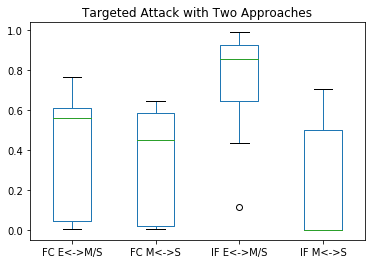

In [49]:
s1 = pd.Series(results_all[0])
s2 = pd.Series(results_all[1])
s3 = pd.Series(results_all[2])
s4 = pd.Series(results_all[3])

df = pd.DataFrame({'IF E<->M/S':s1, 'IF M<->S':s2, 'FC E<->M/S':s3, 'FC M<->S':s4})
df=df.astype(float)
df.plot.box()
plt.title('Targeted Attack with Two Approaches')
plt.show()